c:\Users\cjpai\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Mean Absolute Error:  47.033610018736404
Mean Squared Error:  2803.063305911068
R2 Score:  -4.458610223160133
Average difference between actual and predicted values: 39.16%


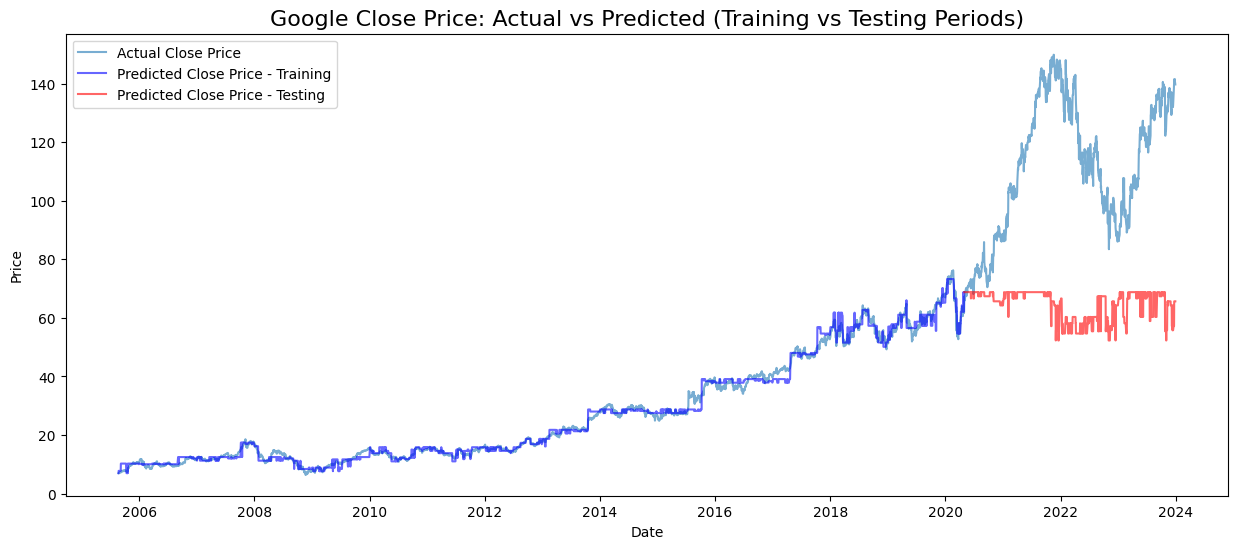


Google Feature Importance:
Yearly_MA: 0.9858547651555227
OBV: 0.005193835275121114
Year: 0.004476901592843657
ATR: 0.002838156148912635
RSI: 0.0010102818069515538
Month: 0.0006260600206482801
Garman Klass Vol: 0.0
Day: 0.0


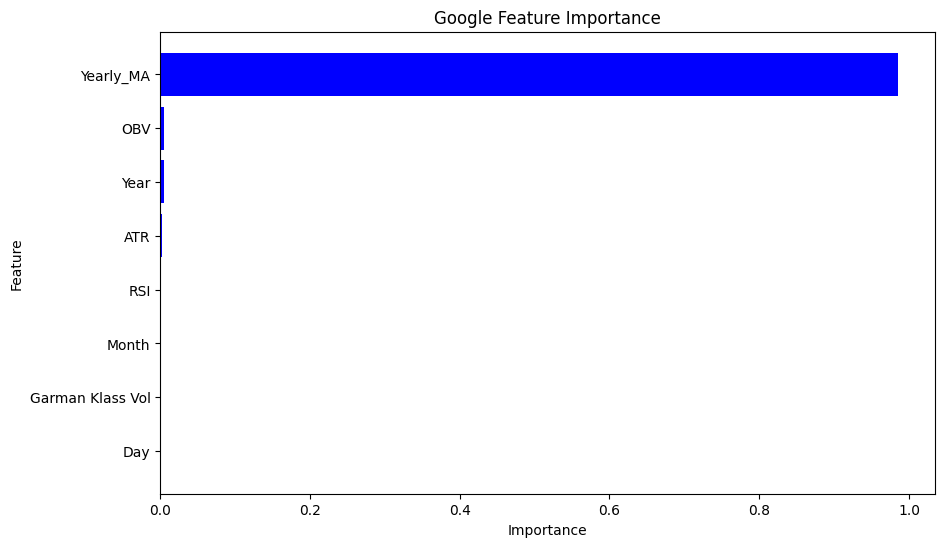

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
import matplotlib.pyplot as plt

# Download Google's stock data from its IPO date till now
data = yf.download('GOOGL', start='2004-08-19', end='2024-01-01')

# Add new features
data['RSI'] = ta.rsi(data['Close'])
data['OBV'] = ta.obv(data['Close'], data['Volume'])
data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'])
data['Yearly_MA'] = data['Close'].rolling(window=256).mean()
data['Garman Klass Vol'] = ((np.log(data['High']) - np.log(data['Low'])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(data['Adj Close']) - np.log(data['Open'])) ** 2)
data['Day'] = data.index.dayofweek
data['Month'] = data.index.month
data['Year'] = data.index.year

# Drop missing values
data = data.dropna()

# Keep only the 'Close' and the new features
data = data[['Close', 'RSI', 'OBV', 'ATR', 'Yearly_MA', 'Garman Klass Vol', 'Day', 'Month', 'Year']]

# Define features and target variable
X = data.drop('Close', axis=1)
y = data['Close']

# Build Random Forest model to precict 'Close'

# Seperate features and target
X = data.drop('Close', axis=1)
y = data['Close']

# Create scaler instance, then scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build Model
model = GradientBoostingRegressor(n_estimators=4, learning_rate=1.0, random_state=42, max_depth=3)

# Train model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate the performance metrics
MAE = mean_absolute_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
R2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: ", MAE)
print(f"Mean Squared Error: ", MSE)
print(f"R2 Score: ", R2)

# Calculate the average difference between the actual and predicted values as a percentage
average_difference = np.mean(np.abs(predictions - y_test.values) / y_test.values) * 100
print(f"Average difference between actual and predicted values: {average_difference:.2f}%")

# 1. Scale the entire dataset (X)
X_scaled_full = scaler.transform(X)

# 2. Make predictions on the entire scaled dataset
predictions_full = model.predict(X_scaled_full)

# Calculate the split index
split_idx = len(X_train)

# Dates for plotting
dates = data.index

# Actual Close prices plotting remains the same
plt.figure(figsize=(15, 6))
plt.plot(dates, y, label='Actual Close Price', alpha=0.6)

# Plot predicted values for the training period
plt.plot(dates[:split_idx], predictions_full[:split_idx], label='Predicted Close Price - Training', color='blue', alpha=0.6)

# Plot predicted values for the testing period
plt.plot(dates[split_idx:], predictions_full[split_idx:], label='Predicted Close Price - Testing', color='red', alpha=0.6)

plt.title('Google Close Price: Actual vs Predicted (Training vs Testing Periods)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Feature Importance
feature_importance = model.feature_importances_
feature_names = X.columns

sorted_feature_importance = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

feature_importance_dict = dict(sorted_feature_importance)

print('\nGoogle Feature Importance:')
plt.figure(figsize=(10, 6))
for feature, importance in sorted_feature_importance:
    print(f'{feature}: {importance}')
    plt.barh(feature, importance, color='blue')

plt.title('Google Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # invert the y-axis to have the most important feature at the top
plt.show()